In [1]:
from kafka import KafkaConsumer
import pandas as pd
import pickle
from sklearn.metrics import f1_score
import warnings
warnings.simplefilter("ignore")

In [2]:
TOPIC_NAME = "dns_exfiltration_detection"
consumer = KafkaConsumer(TOPIC_NAME, bootstrap_servers = 'localhost:9092',
auto_offset_reset='earliest',
enable_auto_commit=False)

In [5]:
# Lets check the data stream
for i, msg in enumerate(consumer):
    msg = str(msg.value, 'utf-8')
    print(f"Row {i}: {msg}")

Row 0: "\u00ef\u00bb\u00bftimestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack\n"
Row 1: "20:54.9,13,0,0,12,0,2.781301471,1,2,10,6,games,gamesisart,11,0,0\n"
Row 2: "40:06.7,25,8,0,10,9,2.786215626,6,6,7,3.333333333,2,192,12,1,0\n"
Row 3: "26:34.8,8,0,0,6,0,2.154135417,2,2,5,3.5,cm,cm-tv,6,0,0\n"
Row 4: "27:12.4,20,3,0,18,0,2.905639062,2,3,12,6,cacao,leyaeducacao,16,1,0\n"
Row 5: "39:19.0,27,10,0,10,11,2.767194749,6,6,7,3.666666667,2,192,14,1,1\n"
Row 6: "04:39.5,11,0,0,10,0,2.067168057,1,2,8,5,motor,promotor,9,0,0\n"
Row 7: "09:24.7,27,10,0,10,11,2.57041707,6,6,7,3.666666667,2,192,14,1,0\n"
Row 8: "58:17.4,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,1\n"
Row 9: "52:31.9,25,8,0,10,9,2.556641667,6,6,7,3.333333333,2,192,12,1,0\n"
Row 10: "16:00.6,24,7,0,10,8,2.054028744,6,6,7,3.166666667,4,224,11,1,1\n"


KeyboardInterrupt: 

In [9]:
# Replace " and \n with no_character, and split with , to get an array of elements
for i, msg in enumerate(consumer):
    if i == 0: continue
    msg = str(msg.value, 'utf-8').replace('"', '').replace('\\n', '').split(',')
    print(f"Row {i}: {msg}")

Row 1: ['20:54.9', '13', '0', '0', '12', '0', '2.781301471', '1', '2', '10', '6', 'games', 'gamesisart', '11', '0', '0']
Row 2: ['40:06.7', '25', '8', '0', '10', '9', '2.786215626', '6', '6', '7', '3.333333333', '2', '192', '12', '1', '0']
Row 3: ['26:34.8', '8', '0', '0', '6', '0', '2.154135417', '2', '2', '5', '3.5', 'cm', 'cm-tv', '6', '0', '0']
Row 4: ['27:12.4', '20', '3', '0', '18', '0', '2.905639062', '2', '3', '12', '6', 'cacao', 'leyaeducacao', '16', '1', '0']
Row 5: ['39:19.0', '27', '10', '0', '10', '11', '2.767194749', '6', '6', '7', '3.666666667', '2', '192', '14', '1', '1']
Row 6: ['04:39.5', '11', '0', '0', '10', '0', '2.067168057', '1', '2', '8', '5', 'motor', 'promotor', '9', '0', '0']
Row 7: ['09:24.7', '27', '10', '0', '10', '11', '2.57041707', '6', '6', '7', '3.666666667', '2', '192', '14', '1', '0']
Row 8: ['58:17.4', '24', '7', '0', '10', '8', '2.054028744', '6', '6', '7', '3.166666667', '4', '224', '11', '1', '1']
Row 9: ['52:31.9', '25', '8', '0', '10', '9', '2.

KeyboardInterrupt: 

In [3]:
all_cols = ['timestamp', 'FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric',
                             'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'longest_word', 'sld',
                             'len','subdomain','Target Attack']
x_cols = ['FQDN_count', 'subdomain_length', 'lower', 'numeric', 'entropy', 'special', 'labels', 'len','subdomain']
y_cols = ['Target Attack']


In [4]:
model = pickle.load(open('LGBM_model.pkl', 'rb'))
df = pd.DataFrame(columns = all_cols)
x_df = pd.DataFrame(columns = x_cols) # Storing all the datapoints for dynamic model update
y_df = pd.DataFrame(columns = y_cols)
f1_scores = []

for i, msg in enumerate(consumer):
    if i == 0: continue
    msg = str(msg.value, 'utf-8').replace('"', '').replace('\\n', '').split(',')
    # for j in numeric_col:
    #     msg[j] = float(msg[j])
    df = pd.concat([df, pd.DataFrame([msg], columns = all_cols)])

    if i % 10000 ==0:
        df = df.reset_index().drop('index', axis=1)
        x = df[x_cols].astype('float')
        y = df[y_cols].astype('float')

        y_pred = model.predict(x)
        f1 = round(f1_score(y, y_pred),2)
        print(f"F1 score for batch {i/10000}: {f1}")
        f1_scores.append(f1)

        df = pd.DataFrame(columns = all_cols)

        # Storing all datapoints for dynamic model update
        x_df = pd.concat([x_df, x])
        y_df = pd.concat([y_df, y])

        if f1 <0.86:
            model.fit(x_df, y_df)
            print('Model updated')
            y_new = model.predict(x)
            f1_new = round(f1_score(y, y_new),2)
            print(f'New F1 score: {f1_new}\n')

            f1_scores.pop() # Removing the old F1-score
            f1_scores.append(f1_new)# Adding the new F1-score
# Streamed all data 268065 rows of data in 26 batches

F1 score for batch 1.0: 0.85
Model updated
New F1 score: 0.86

F1 score for batch 2.0: 0.86
F1 score for batch 3.0: 0.85
Model updated
New F1 score: 0.86

F1 score for batch 4.0: 0.85
Model updated
New F1 score: 0.85

F1 score for batch 5.0: 0.86
F1 score for batch 6.0: 0.86
F1 score for batch 7.0: 0.85
Model updated
New F1 score: 0.85

F1 score for batch 8.0: 0.86
F1 score for batch 9.0: 0.85
Model updated
New F1 score: 0.85

F1 score for batch 10.0: 0.85
Model updated
New F1 score: 0.85

F1 score for batch 11.0: 0.86
F1 score for batch 12.0: 0.85
Model updated
New F1 score: 0.85

F1 score for batch 13.0: 0.86
F1 score for batch 14.0: 0.86
F1 score for batch 15.0: 0.86
F1 score for batch 16.0: 0.86
F1 score for batch 17.0: 0.86
F1 score for batch 18.0: 0.86
F1 score for batch 19.0: 0.86
F1 score for batch 20.0: 0.86
F1 score for batch 21.0: 0.85
Model updated
New F1 score: 0.85

F1 score for batch 22.0: 0.86
F1 score for batch 23.0: 0.86
F1 score for batch 24.0: 0.85
Model updated
New

KeyboardInterrupt: 

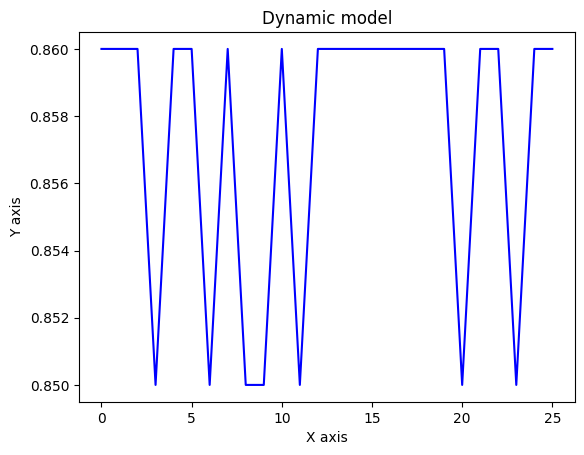

In [7]:
import numpy as np
import matplotlib.pyplot as plt
 
plt.title("Dynamic model")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.plot(f1_scores, color ="Blue")
plt.show()